## Introduction
I have never considered myself an extraverted person.

I am not naturally what one might call “the life of the party.” I do not seek attention, and find it diffcult to be energised by large groups of people. However, I observed that personality tests often reduce extraversion to a simple score, a number that supposedly captures how social, outgoing, or talkative someone is.

That raised a deeper question for me; what actually makes a person extraverted?

Is extraversion about confidence? About social warmth? About emotional stability? Or is it simply about talking more?

In this blog, I will explore responses from nearly 20,000 people who completed the Big Five personality test. Instead of just accepting extraversion as a fixed label I will try to look at how different behaviours fit together, how extraversion connects to other personality traits, and whether factors like cultural background make much difference. Ultimately, I’m trying to understand the components of an extraverted person.

#### Setup

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

big5_df = pd.read_csv('data/openpsych_data.csv', sep='\t')

# Assigning race category based on race number.
race_values = '''1=Mixed Race, 2=Arctic (Siberian, Eskimo), 3=Caucasian (European), 
4=Caucasian (Indian), 5=Caucasian (Middle East), 6=Caucasian (North African, Other), 
7=Indigenous Australian, 8=Native American, 
9=North East Asian (Mongol, Tibetan, Korean Japanese, etc), 
10=Pacific (Polynesian, Micronesian, etc), 
11=South East Asian (Chinese, Thai, Malay, Filipino, etc), 12=West African, Bushmen, Ethiopian, 13=Other, 0=missed
'''

parts = re.split(r'(?:,\s+)?([0-9]+)=', race_values.strip())

race_keys = [int(key_val) for key_val in parts[1::2]]
race_values = parts[2::2]

race_mapping = dict(zip(race_keys,race_values))

big5_df = big5_df.assign(race_cat=big5_df['race'].map(race_mapping))

# Removing invalid ages.
big5_df = big5_df.query("age <= 120")

# Labelling the genders given the gender number
gender_map = {
    0: pd.NA,
    1: 'male',
    2: 'female',
    3: 'other'
}
big5_df = big5_df.assign(gender_cat=big5_df['gender'].map(gender_map))

In [2]:
# Computing scores for each category.
factor_map = { 1: 'E', 
               2: 'A',
               3: 'C',
               4: 'N',
               5: 'O' }

ipip_df = pd.read_html('data/big5_questions.html', header=0)[0]
ipip_df = ipip_df.rename(columns={'Unnamed: 1': 'text', 'Unnamed: 7': 'factor_and_direction'})[['text','factor_and_direction']]
ipip_df[['factor','direction']]=ipip_df['factor_and_direction'].str.extract(r'([1-5])(.)')
ipip_df['category']=ipip_df['factor'].astype(int).map(factor_map)

ipip_df = ipip_df.assign(number=np.repeat(np.arange(1,11),5))
ipip_df = ipip_df.assign(qcode=ipip_df['category'].str.cat(ipip_df['number'].astype(str)))   

neg_items = ipip_df.query('direction=="-"')['qcode']

big5_scored_df = big5_df.copy()
big5_scored_df[neg_items] = 6-big5_df[neg_items]

cat_cols = {
    cat : [f'{cat}{n+1}' for n in range(10)] 
    for cat in ('O','C','E','A','N') 
}

for cat, cols in cat_cols.items():
    big5_scored_df[cat]=big5_scored_df[cols].sum(axis=1)

## Which broader personality traits are associated with extraversion?
We will attempt to determine whether extraversion is a trait which exists in isolation, or is correlated to an individual's scores for agreeableness, conscientiousness, neuroticism and openness. Through this, we can determine if an extraverted individual differs systematically in other dimensions of their personality than others.

In [3]:
traits = ['E', 'A', 'C', 'N', 'O']

traits_df = big5_scored_df[traits]

corr = traits_df.corr()

trait_labels = {
    'A': 'Agreeableness',
    'C': 'Conscientiousness',
    'N': 'Emotional Stability',
    'O': 'Openness'
}

E_corr = (
    corr['E']
    .drop('E')
    .rename(index=trait_labels)
    .sort_values(ascending = False)
    .to_frame(name='Correlation with Extraversion')
)

E_corr

,Correlation with Extraversion
Agreeableness,0.334194
Emotional Stability,0.262948
Openness,0.166726
Conscientiousness,0.105204


From the correlation table, extraversion shows its strongest association with agreeableness (r ≈ 0.33), indicating that individuals who score higher on extraversion also tend to score higher on agreeableness. This suggests that, in this dataset, extraversion is linked not only to sociability but extraverted individuals tend to be more accepted in social situations. They may generally be more inclined to be able to avoid conflict or respond in a more sympathetic manner to others' emotions.

There is also a moderate positive correlation between extraversion and emotional stability (r ≈ 0.26). This implies that more extraverted individuals tend to, on average, have slightly lower emotional reactivity, meaning they are calmer and less prone to stress. This means they typically enjoy initiating conversations or enjoy social interaction in general. However, the relationship is moderate rather than strong, indicating a slightly weaker correlation than with agreeableness.

In contrast, the correlations between extraversion and both openness and conscientiousness are relatively weak. This suggests that extraversion in this dataset is primarily associated with social and emotional tendencies, rather than intellectual curiosity or self-discipline.

## Is extraversion related to one's ethinicity?
We will now attempt to determine if whether or not there are any observable differences in average extraversion scores based on the ethnic groups in which individuals have associated themselves to. 

I wanted to explore this relationship because cultural norms in relation to expressiveness, social hierarchy and conformity vary across different racial / ethic groups. Personally, growing up in an Asian household, I believe that restraint and conformity is a value often imposed in my culture, which I believe contributed to my lower levels of extrovertedness.

But is this really true?

<Figure size 1000x800 with 0 Axes>

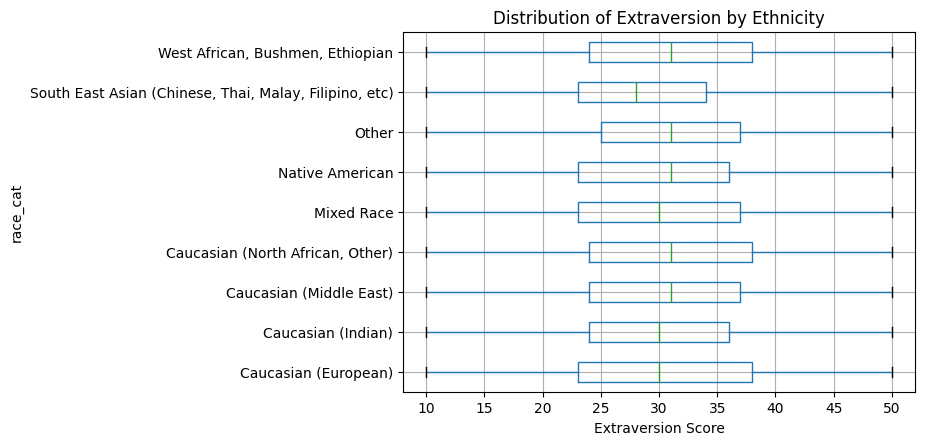

In [4]:
df_race = big5_scored_df[['E', 'race_cat']].copy()

race_summary = df_race.groupby('race_cat').agg(n=('E', 'size'), mean_E=('E', 'mean'), sd_E=('E', 'std'))

race_summary['se_E'] = race_summary['sd_E'] / np.sqrt(race_summary['n'])
race_summary = race_summary.sort_values('mean_E', ascending=False)

# Setting a minimum number for the size of the racial group for more statistically accurate results.
MIN_N = 200

race_summary_f = race_summary[race_summary['n'] >= MIN_N].copy()
race_summary_f

valid_groups = race_summary_f.index
df_plot = df_race[df_race['race_cat'].isin(valid_groups)]

plt.figure(figsize=(10, 8))
df_plot.boxplot(column='E', by='race_cat', vert=False)

plt.xlabel("Extraversion Score")
plt.title("Distribution of Extraversion by Ethnicity")
plt.suptitle("")
plt.show()

The bloxplot shows that there is substantial overlap in the distribution of extraversion scoress across different ethnic categories.

Although there are small difference in median values, the overall spread of scores is similar across different groups. The results suggest that while modest differences in average extraversion may exist across racial groups in this dataset, the majority of variation in extraversion occurs within groups rather than between them.

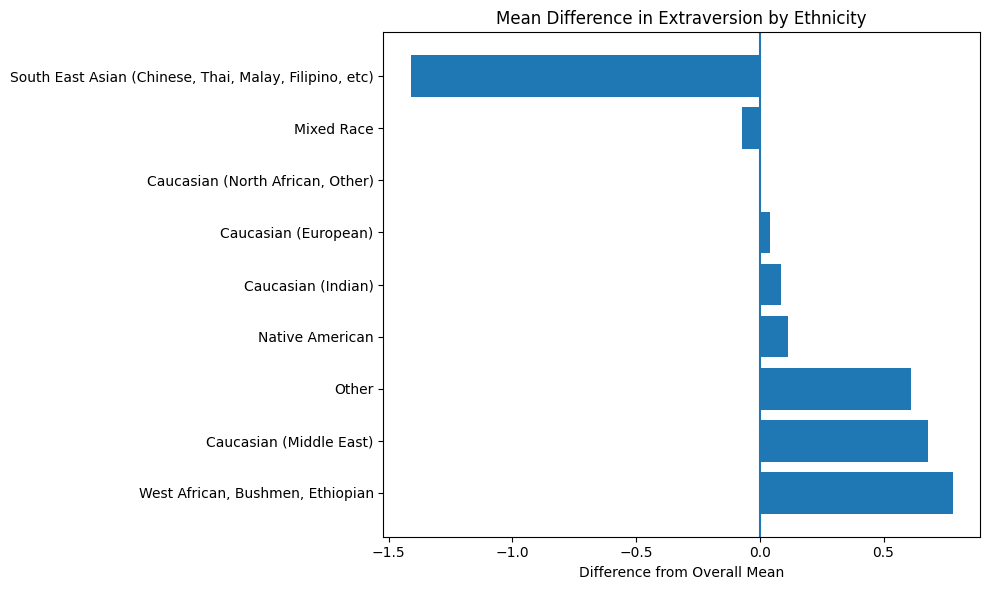

Max deviation: 0.78, Min deviation: -1.41, Range: 2.19

Exact deviations from overall mean:

West African, Bushmen, Ethiopian: 0.78
Caucasian (Middle East): 0.68
Other: 0.61
Native American: 0.11
Caucasian (Indian): 0.08
Caucasian (European): 0.04
Caucasian (North African, Other): 0.00
Mixed Race: -0.07
South East Asian (Chinese, Thai, Malay, Filipino, etc): -1.41


In [5]:
overall_mean = df_plot['E'].mean()

race_summary_f['mean_diff'] = race_summary_f['mean_E'] - overall_mean

plt.figure(figsize=(10,6))
plt.barh(race_summary_f.index, race_summary_f['mean_diff'])
plt.axvline(0)
plt.xlabel("Difference from Overall Mean")
plt.title("Mean Difference in Extraversion by Ethnicity")
plt.tight_layout()
plt.show()

max_dev = race_summary_f['mean_diff'].max().round(2)
min_dev = race_summary_f['mean_diff'].min().round(2)

range_dev = max_dev - min_dev

print(f"Max deviation: {max_dev}, Min deviation: {min_dev}, Range: {range_dev}")

race_summary_f_sorted = race_summary_f.sort_values(
    'mean_diff',
    ascending=False
)

# Printing exact deviations away from the overall mean for each ethnic group
print("\nExact deviations from overall mean:\n")

for group, row in race_summary_f_sorted.iterrows():
    print(f"{group}: {row['mean_diff']:.2f}")

The second plot displays the deviation of each ethnic group’s mean extraversion score from the overall sample average. Although the differences are relatively small, with a total range of approximately 2.19 points, there are still observable variations from the overall mean across groups.

South East Asian respondents have the lowest average extraversion score relative to the overall mean, scoring about 1.41 points below it. In contrast, West African, Bushmen, Ethiopian respondents show the largest positive deviation at approximately 0.78 points above the mean. Caucasian (Middle East) and Other categories also sit modestly above the overall average, at roughly 0.68 and 0.61 points higher, respectively.

These results align slightly with my personal account of my cultural norms. However, the difference from the overall mean is relatively small when considered in relation to the much larger range of possible extraversion scores, which span from 10 to 50. The observed deviation in extraversion score of approximately 1.41 points from the overall mean represents only a small fraction of the total scale, implying that ethnic differences don't contribute too strongly to overall extraversion.

## Is extraversion defined by specific dominant behaviours, or is it a broader social orientation?
Each personality trait score in the Big Five framework is calculated from ten individual questions. While these items are intended to measure a single underlying construct, this raises an important question: does extraversion reflect one particularly dominant behavioural tendency, such as talkativeness or attention-seeking, or does it instead capture a broader aspect of social interaction?

Although the Big Five framework assumes that these items collectively measure a unified trait, it is not immediately obvious whether all behaviours (questions) contribute equally. The following analysis will examine whether a single behaviour dominates the structure of the trait or whether extraversion is derived from a balance between behaviours.

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select E1–E10
E_cols = [f'E{i}' for i in range(1, 11)]
E_data = big5_scored_df[E_cols].copy()

# Drop missing values if any
E_data = E_data.dropna()

scaler = StandardScaler()
E_scaled = scaler.fit_transform(E_data)

pca = PCA()
pca.fit(E_scaled)

E_pca = pca.transform(E_scaled)

explained_variance = pd.Series(
    pca.explained_variance_ratio_,
    index=[f'PC{i}' for i in range(1, 11)]
)

explained_variance.round(3)

PC1     0.512
PC2     0.090
PC3     0.081
PC4     0.059
PC5     0.053
PC6     0.046
PC7     0.045
PC8     0.041
PC9     0.039
PC10    0.033
dtype: float64

In [7]:
pc1_loadings = loadings['PC1'].sort_values(ascending=False)

pc1_loadings.round(3)

NameError: name 'loadings' is not defined

In [ ]:
plt.figure(figsize=(8,5))
pc1_loadings.plot(kind='bar')
plt.title("PC1 Loadings for Extraversion Items")
plt.ylabel("Loading")
plt.tight_layout()
plt.show()

Analysing the loadings of first principal component (which is usually the most statsitically significant), we can conclude which aspects of one's behaviour contribute to extrovertedness. The loadings represent how strongly the question aligns / contributes to the extraversion measure. 

Looking at the loadings shown above, we can see that there is very little variation, with the loadings ranging from 0.266 to 0.348. This relatively narrow range indicates that no single behaviour overwhelmingly defines extraversion. Instead, each of the 10 questions contribute in a broadly similar to an individual's level of extraversion.

However, there are specific questions which have greater loading. Here are the top three questions:
1. E5: "Start conversations."
2. E7: "Talk to a lot of different people at parties."
3. E4: "Keep in the background."

All of these questions are in relation to active outward engagement or initiative, rather than questions around being socially comfortable (E3, E10) or being the center of attention / craving attention (E1, E9, E8) or around how much one talks (E2, E6). From this, we can conclude that although all 10 questions contribute similarly, initiative and social engagement play a slightly greater role in determining an individual's extraversion score.

## Final Comments
At the beginning of this post, I asked what actually makes someone extraverted. Is it confidence, warmth, emotional stability, or simply talking more?

Looking at how extraversion relates to other personality traits, we saw that it is most strongly associated with agreeableness and moderately associated with emotional stability. This suggests that individuals who score higher on extraversion in this dataset also tend to be more socially warm, and somewhat calmer in their emotional responses. Extraversion appears to sit within a broader social and emotional profile rather than functioning as a standalone characteristic.

When examining differences across ethnic groups, the variation in average extraversion scores was relatively modest. Although some groups sat slightly above or below the overall mean, the differences wer small when compared to the full 10 to 50 range of the scale. Most of the variation in extraversion occured within groups rather than between them. This suggests that while cultural background may shape behaviour to some extent, extraversion in this dataset is primarily driven by individual differences.

Finally, analysing the internal structure of extraversion through Principal Component Analysis showed that no single behaviour overwhelmingly defines the trait. All ten questions contributed in broadly similar ways. However, behaviours related to initiating conversations and engaging actively with others showed slightly stronger alignment with the dominant component. This indicates that extraversion is less about simply talking more or seeking attention, and more about a consistent tendency to step into social situations and participate actively.

Taken together, these findings provide a clearer answer to the question I began with. What actually "makes" an extraverted person is not one single defining behaviour, nor a single cultural influence, nor just emotional steadiness. Rather, it is a consistent inclination to engage with others and to step forward socially.